In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import preprocessing

# Models 
# -----------------------------------
import lightgbm as lgb
import xgboost
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
# Metrics & Evaluation
# -----------------------------------
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [4]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

In [5]:
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

# Functions

**Outlier Analysis**

**Missing Value Analysis**

**Other Missing Value**

**Rare Analyser**

# Data

In [14]:
df = df_train.append(df_test).reset_index(drop=True)
df.shape

(2919, 81)

In [15]:
df.value_counts(np.where(df["SalePrice"]>0,'1','0'))

1    1460
0    1459
dtype: int64

# Missing Values

In [16]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


**CATEGORICAL COLUMNS**

In [17]:
for col in cat_cols:
    cat_summary(df, col)

         MSZoning      Ratio
RL           2265  77.595067
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458
      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111
      Alley     Ratio
Grvl    120  4.110997
Pave     78  2.672148
     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133
     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498
        Utilities      Ratio
AllPub       2916  99.897225
NoSeWa          1   0.034258
         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.505995
CulDSac        176   6.029462
FR2             85   2.911956
FR3             14   0.479616
     LandSlope      Ratio
Gtl       2778  95.169579
Mod        125   4.282288
Sev         16   0.548133
        Condition1      Ratio
Norm          2511  86.02261

**NUMERICAL COLUMNS**

In [18]:
df[num_cols].describe([0.05, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,95%,99%,max
Id,2919.0,1460.000000,842.787043,1.0,146.90,292.8,730.5,1460.0,2189.5,2773.10,2889.82,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.00,20.0,20.0,50.0,70.0,160.00,190.00,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,32.00,43.0,59.0,68.0,80.0,107.00,135.68,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,3182.00,4922.4,7478.0,9453.0,11570.0,17142.90,33038.64,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,4.00,5.0,5.0,6.0,7.0,8.00,10.00,10.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1915.00,1924.0,1953.5,1973.0,2001.0,2007.00,2008.00,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1950.00,1950.0,1965.0,1993.0,2004.0,2007.00,2009.00,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.00,0.0,0.0,0.0,164.0,466.50,771.05,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.00,0.0,0.0,368.5,733.0,1274.00,1635.32,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.00,0.0,0.0,0.0,0.0,435.00,874.66,1526.0


In [19]:
for col in num_cols:
    num_summary(df, col)

count    2919.000000
mean     1460.000000
std       842.787043
min         1.000000
5%        146.900000
10%       292.800000
20%       584.600000
30%       876.400000
40%      1168.200000
50%      1460.000000
60%      1751.800000
70%      2043.600000
80%      2335.400000
90%      2627.200000
95%      2773.100000
99%      2889.820000
max      2919.000000
Name: Id, dtype: float64
count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
5%         20.000000
10%        20.000000
20%        20.000000
30%        20.000000
40%        30.000000
50%        50.000000
60%        60.000000
70%        60.000000
80%        80.000000
90%       120.000000
95%       160.000000
99%       190.000000
max       190.000000
Name: MSSubClass, dtype: float64
count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
5%         32.000000
10%        43.000000
20%        53.000000
30%        60.000000
40%        63.000000
50%        68.000000
60%        73.0000

# Correlation Analysis

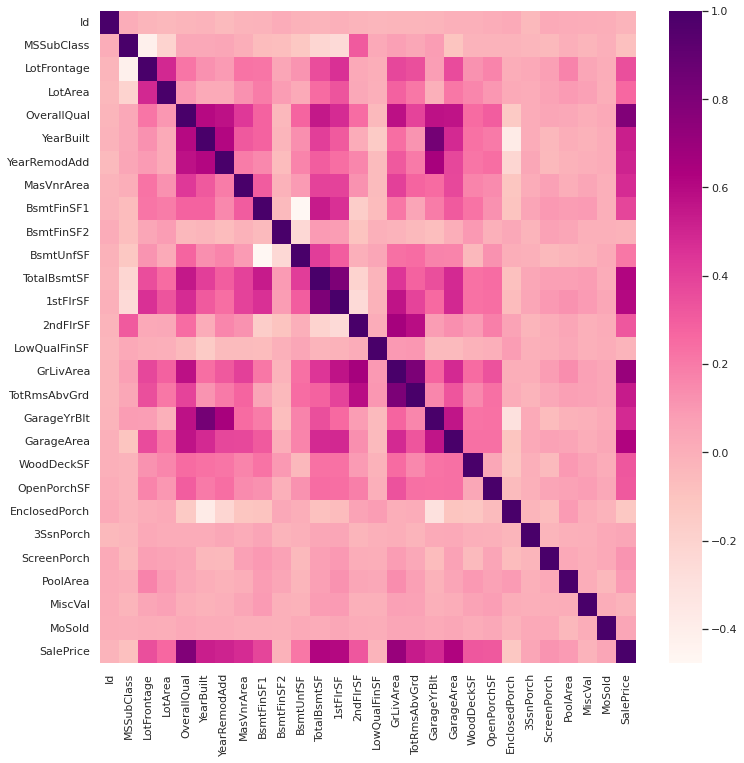

In [20]:
corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdPu")
plt.show(block=True)

In [21]:
high_correlated_cols(df, plot=False)

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice']

**Outlier Observation Analysis**

In [22]:
for col in num_cols:
    if col != "SalePrice":
      print(col, check_outlier(df, col))

Id False
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False


**Suppression of Outliers**

In [23]:
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

**MISSING VALUES**

In [24]:
missing_values_table(df)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [25]:
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]


# Filling the spaces in the columns with the expression "No"
for col in no_cols:
    df[col].fillna("No",inplace=True)

missing_values_table(df)

              n_miss  ratio
SalePrice       1459  49.98
LotFrontage      486  16.65
GarageYrBlt      159   5.45
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
BsmtFullBath       2   0.07
BsmtHalfBath       2   0.07
Functional         2   0.07
Utilities          2   0.07
Exterior2nd        1   0.03
BsmtFinSF1         1   0.03
BsmtFinSF2         1   0.03
BsmtUnfSF          1   0.03
Exterior1st        1   0.03
Electrical         1   0.03
KitchenQual        1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
SaleType           1   0.03
TotalBsmtSF        1   0.03


In [26]:
# Other Missing Values
df = quick_missing_imp(df, num_method="median", cat_length=17)

# BEFORE
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

MSZoning           0
LotFrontage        0
Utilities          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Electrical         0
BsmtFullBath       0
BsmtHalfBath       0
KitchenQual        0
Functional         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SaleType      

**Rare:** MSZoning, LotShape, ExterCond, GarageQual, BsmtFinType2 , Condition1 , BldgType 

**Deleting:** Street, Alley, LandContour, Utilities, LandSlope, Condition2, Heating, CentralAir, Functional, PoolQC, MiscFeature, Neighborhood, KitchenAbvGr

**RARE ANALYZER**

In [27]:
rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
         COUNT     RATIO    TARGET_MEAN
C (all)     25  0.008565   74528.000000
FV         139  0.047619  214014.061538
RH          26  0.008907  131558.375000
RL        2269  0.777321  191004.994787
RM         460  0.157588  126316.830275


Street : 2
      COUNT     RATIO    TARGET_MEAN
Grvl     12  0.004111  130190.500000
Pave   2907  0.995889  181130.538514


Alley : 3
      COUNT     RATIO    TARGET_MEAN
Grvl    120  0.041110  122219.080000
No     2721  0.932169  183452.131483
Pave     78  0.026721  168000.585366


LotShape : 4
     COUNT     RATIO    TARGET_MEAN
IR1    968  0.331620  206101.665289
IR2     76  0.026036  239833.365854
IR3     16  0.005481  216036.500000
Reg   1859  0.636862  164754.818378


LandContour : 4
     COUNT     RATIO    TARGET_MEAN
Bnk    117  0.040082  143104.079365
HLS    120  0.041110  231533.940000
Low     60  0.020555  203661.111111
Lvl   2622  0.898253  180183.746758


Utilities : 2
        COUNT     RATIO   TARGET_MEAN
AllPub   2918  0

# Feature Engineering

**MSZoning** 

In [28]:
df["MSZoning"].value_counts()

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [29]:
df.loc[(df["MSZoning"] == "RH"), "MSZoning"] = "RM"
df.loc[(df["MSZoning"] == "FV"), "MSZoning"] = "FV + C (all)"
df.loc[(df["MSZoning"] == "C (all)"), "MSZoning"] = "FV + C (all)"
df["MSZoning"].value_counts()

RL              2269
RM               486
FV + C (all)     164
Name: MSZoning, dtype: int64

**Lot Area**


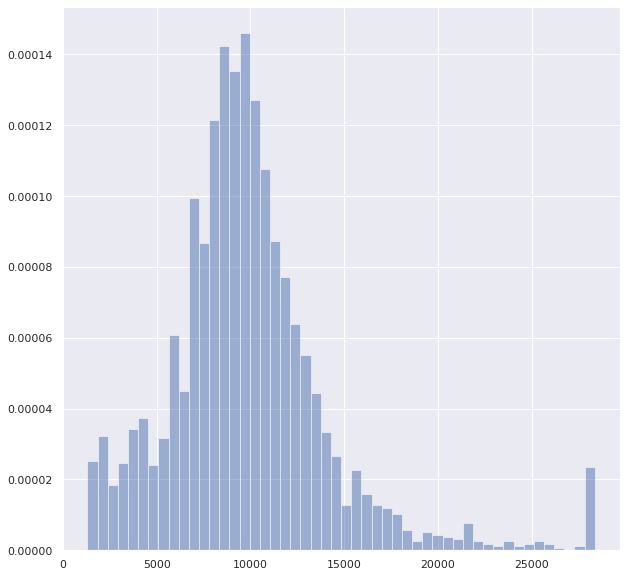

In [30]:
sns.set(rc={'figure.figsize': (10, 10)})
bins = 50
plt.hist(df["LotArea"],bins, alpha=0.5, density=True)
plt.show()

In [31]:
df["LotArea"].max()

28367.9

In [32]:
df['LotArea'].mean()

9818.098081534772

In [33]:
df['LotArea'].value_counts()

9600.0     44
7200.0     43
28367.9    37
6000.0     34
9000.0     29
           ..
15863.0     1
7082.0      1
9492.0      1
9300.0      1
10441.0     1
Name: LotArea, Length: 1915, dtype: int64

In [34]:
New_LotArea =  pd.Series(["Studio","Small", "Middle", "Large","Dublex","Luxury"], dtype = "category")
df["New_LotArea"] = New_LotArea
df.loc[(df["LotArea"] <= 2000), "New_LotArea"] = New_LotArea[0]
df.loc[(df["LotArea"] > 2000) & (df["LotArea"] <= 4000), "New_LotArea"] = New_LotArea[1]
df.loc[(df["LotArea"] > 4000) & (df["LotArea"] <= 6000), "New_LotArea"] = New_LotArea[2]
df.loc[(df["LotArea"] > 6000) & (df["LotArea"] <= 8000), "New_LotArea"] = New_LotArea[3]
df.loc[(df["LotArea"] > 10000) & (df["LotArea"] <= 12000), "New_LotArea"] = New_LotArea[4]
df.loc[df["LotArea"] > 12000 ,"New_LotArea"] = New_LotArea[5]

In [35]:
df["New_LotArea"].value_counts()

Luxury    624
Dublex    594
Large     463
Middle    216
Small     157
Studio     58
Name: New_LotArea, dtype: int64

**LotShape**

In [36]:
df["LotShape"].value_counts()

Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64

In [37]:
df.loc[(df["LotShape"] == "IR1"), "LotShape"] = "IR"
df.loc[(df["LotShape"] == "IR2"), "LotShape"] = "IR"
df.loc[(df["LotShape"] == "IR3"), "LotShape"] = "IR"

In [38]:
df["LotShape"].value_counts()

Reg    1859
IR     1060
Name: LotShape, dtype: int64

**ExterCond**



In [39]:
df["ExterCond"].value_counts()

TA    2538
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64

In [40]:
df["ExterCond"] = np.where(df.ExterCond.isin(["Fa", "Po"]), "FaPo", df["ExterCond"])
df["ExterCond"] = np.where(df.ExterCond.isin(["Ex", "Gd"]), "ExGd", df["ExterCond"])
df['ExterCond'].value_counts()

TA      2538
ExGd     311
FaPo      70
Name: ExterCond, dtype: int64

**GarageQual**

In [41]:
df['GarageQual'].value_counts()

TA    2604
No     159
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64

In [42]:
df["GarageQual"] = np.where(df.GarageQual.isin(["Fa", "Po"]), "FaPo", df["GarageQual"])
df["GarageQual"] = np.where(df.GarageQual.isin(["Ex", "Gd"]), "ExGd", df["GarageQual"])
df["GarageQual"] = np.where(df.GarageQual.isin(["ExGd", "TA"]), "ExGd", df["GarageQual"])
df['GarageQual'].value_counts()

ExGd    2631
No       159
FaPo     129
Name: GarageQual, dtype: int64

**BsmtFinType1** and **BsmtFinType2**

In [43]:
df['BsmtFinType1'].value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
No      79
Name: BsmtFinType1, dtype: int64

In [44]:
df['BsmtFinType2'].value_counts()

Unf    2493
Rec     105
LwQ      87
No       80
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

In [45]:
df["BsmtFinType1"] = np.where(df.BsmtFinType1.isin(["GLQ", "ALQ"]), "RareExcellent", df["BsmtFinType1"])
df["BsmtFinType1"] = np.where(df.BsmtFinType1.isin(["BLQ", "LwQ", "Rec"]), "RareGood", df["BsmtFinType1"])
df["BsmtFinType2"] = np.where(df.BsmtFinType2.isin(["GLQ", "ALQ"]), "RareExcellent", df["BsmtFinType2"])
df["BsmtFinType2"] = np.where(df.BsmtFinType2.isin(["BLQ", "LwQ", "Rec"]), "RareGood", df["BsmtFinType2"])
df['BsmtFinType1'].value_counts()

RareExcellent    1278
Unf               851
RareGood          711
No                 79
Name: BsmtFinType1, dtype: int64

In [46]:
df['BsmtFinType2'].value_counts()

Unf              2493
RareGood          260
RareExcellent      86
No                 80
Name: BsmtFinType2, dtype: int64

**Condition1**

In [47]:
df['Condition1'].value_counts()

Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [48]:
df.loc[(df["Condition1"] == "Feedr") | (df["Condition1"] == "Artery") |(df["Condition1"] == "RRAn") |(df["Condition1"] == "PosA") | (df["Condition1"] == "RRAe"),"Condition1"] = "AdjacentCondition"
df.loc[(df["Condition1"] == "RRNn") | (df["Condition1"] == "PosN") |(df["Condition1"] == "RRNe"),"Condition1"] = "WithinCondition"
df.loc[(df["Condition1"] == "Norm") ,"Condition1"] = "NormalCondition"
df['Condition1'].value_counts()

NormalCondition      2511
AdjacentCondition     354
WithinCondition        54
Name: Condition1, dtype: int64

**Condition2**

In [49]:
df['Condition2'].value_counts()

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [50]:
df.drop('Condition2',axis=1,inplace=True)

**BldgType**

In [51]:
df['BldgType'].value_counts()

1Fam      2425
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64

In [52]:
df["BldgType"] = np.where(df.BldgType.isin(["1Fam", "2fmCon"]), "Normal", df["BldgType"])
df["BldgType"] = np.where(df.BldgType.isin(["TwnhsE", "Twnhs", "Duplex"]), "Big", df["BldgType"])
df['BldgType'].value_counts()

Normal    2487
Big        432
Name: BldgType, dtype: int64

**Electrical**

In [53]:
df["Electrical"].value_counts()

SBrkr    2672
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [54]:
df["Electrical"] = np.where(df.Electrical.isin(["FuseA", "FuseF", "FuseP", "Mix"]), "Fuse", df["Electrical"])
df["Electrical"].value_counts()

SBrkr    2672
Fuse      247
Name: Electrical, dtype: int64

**Paved Drive**

In [55]:
df["PavedDrive"].value_counts()

Y    2641
N     216
P      62
Name: PavedDrive, dtype: int64

In [56]:
df["PavedDrive"] = np.where(df.PavedDrive.isin(["N","P"]), "N", df["PavedDrive"])
df["PavedDrive"].value_counts()

Y    2641
N     278
Name: PavedDrive, dtype: int64

**Sale Type**

In [57]:
df["SaleType"].value_counts()

WD       2526
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [58]:
df["SaleType"] = np.where(df.SaleType.isin(["ConLw", "ConLI", "ConLD", "Oth",]), "Con", df["SaleType"])
df["SaleType"].value_counts()

WD     2526
New     239
COD      87
Con      55
CWD      12
Name: SaleType, dtype: int64

**Overall**

In [59]:
df["Overall"] = df[["OverallQual", "OverallCond"]].sum(axis = 1)

**NEW_TotalFlrSF**

Total surface area of the house

In [60]:
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"]

**NEW_TotalBsmtFin**

Completed total basement area

In [61]:
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1+df.BsmtFinSF2

**NEW_PorchArea**

Total area outside the house

In [62]:
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF

**NEW_TotalHouseArea**

total area of the house

In [63]:
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF

**NEW_TotalSqFeet**

Total occupancy of the house ft2

In [64]:
df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF

**NEW_TotalFullBath** and **NEW_TotalHalfBath**

Number of half and full bathrooms with the total in the house

In [65]:
df["NEW_TotalFullBath"] = df.BsmtFullBath + df.FullBath
df["NEW_TotalHalfBath"] = df.BsmtHalfBath + df.HalfBath

**NEW_TotalBath**

It represents the total number of bathrooms in the house.

In [66]:
df["NEW_TotalBath"] = df["NEW_TotalFullBath"] + (df["NEW_TotalHalfBath"]*0.5)

**Lot Ratio**

How much of the land is inhabited, total house area and garage area

In [67]:
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea

**Tarihler arasındaki farklar**

Variables such as the last year between the restoration and the year of construction, the difference between the year the garage was built and the year the house was built.

In [68]:
df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd)

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt

In [69]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,NEW_TotalBath,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold
0,1.0,60,RL,65.0,8450.0,Pave,No,Reg,Lvl,AllPub,...,3.5,0.202367,0.303669,0.064852,0.0,5,5.0,0.0,0.0,5.0
1,2.0,20,RL,80.0,9600.0,Pave,No,Reg,Lvl,AllPub,...,2.5,0.131458,0.262917,0.047917,0.0,31,31.0,0.0,0.0,31.0
2,3.0,60,RL,68.0,11250.0,Pave,No,IR,Lvl,AllPub,...,3.5,0.158756,0.240533,0.054044,1.0,7,6.0,0.0,1.0,7.0
3,4.0,70,RL,60.0,9550.0,Pave,No,IR,Lvl,AllPub,...,2.0,0.179791,0.258953,0.067225,55.0,91,36.0,83.0,28.0,8.0
4,5.0,60,RL,84.0,14260.0,Pave,No,IR,Lvl,AllPub,...,3.5,0.154137,0.234432,0.058626,0.0,8,8.0,0.0,0.0,8.0


**Extracting Data From Dataset**

In [70]:
drop_list = ["Street", "Alley", "LandContour", "Utilities" ,"LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood","KitchenAbvGr", "CentralAir", "Functional","RoofMatl",]

df.drop(drop_list, axis=1, inplace=True)

# Label Encoding and One Hot Encoder

In [71]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 86
cat_cols: 47
num_cols: 39
cat_but_car: 0
num_but_cat: 17


In [72]:
def label_encoder(dataframe, binary_col):
    labelencoder = preprocessing.LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O"
               and len(df[col].unique()) == 2]

In [73]:
for col in binary_cols:
    label_encoder(df, col)

In [74]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [75]:
missing_values_table(df)

           n_miss  ratio
SalePrice    1459  49.98


In [76]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()].drop("SalePrice", axis=1)

y = np.log1p(df[df['SalePrice'].notnull()]['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

In [77]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,New_LotArea_Studio,NEW_TotalFullBath_1.0,NEW_TotalFullBath_2.0,NEW_TotalFullBath_3.0,NEW_TotalFullBath_4.0,NEW_TotalFullBath_6.0,NEW_TotalHalfBath_1.0,NEW_TotalHalfBath_2.0,NEW_TotalHalfBath_3.0,NEW_TotalHalfBath_4.0
0,60,65.0,8450.0,7.0,2003,2003.0,196.0,706.0,0.0,150.0,...,1,0,0,1,0,0,1,0,0,0
1,20,80.0,9600.0,6.0,1976,1976.0,0.0,978.0,0.0,284.0,...,0,0,1,0,0,0,1,0,0,0
2,60,68.0,11250.0,7.0,2001,2002.0,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,1,0,0,0
3,70,60.0,9550.0,7.0,1915,1970.0,0.0,216.0,0.0,540.0,...,0,0,1,0,0,0,0,0,0,0
4,60,84.0,14260.0,8.0,2000,2000.0,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917.0,6.0,1999,2000.0,0.0,0.0,0.0,953.0,...,0,0,1,0,0,0,1,0,0,0
1456,20,85.0,13175.0,6.0,1978,1988.0,119.0,790.0,163.0,589.0,...,0,0,0,1,0,0,0,0,0,0
1457,70,66.0,9042.0,7.0,1941,2006.0,0.0,275.0,0.0,877.0,...,0,0,1,0,0,0,0,0,0,0
1458,20,68.0,9717.0,5.0,1950,1996.0,0.0,49.0,314.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [78]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1548 (LR) 
RMSE: 0.2157 (KNN) 
RMSE: 0.2129 (CART) 
RMSE: 0.1431 (RF) 
RMSE: 0.1307 (GBM) 
RMSE: 0.1424 (XGBoost) 
RMSE: 0.1344 (LightGBM) 


In [83]:
#Splitting the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [112]:
gbm_model = GradientBoostingRegressor(random_state=17)

rmse = np.mean(np.sqrt(-cross_val_score(gbm_model,
                                        X, y, cv=5, scoring="neg_mean_squared_error")))

gbm_params = {"learning_rate": [0.01, 0.04, 0.1],
                  "max_depth": [3, 4, 5, 6],
                  "n_estimators": [100, 200, 400, 800, 1000],
                  "subsample": [0.1, 0.4, 0.7, 1]}

gbm_best_params_ = GridSearchCV(gbm_model,
                            gbm_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [113]:
gbm_best_params_.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.4}

In [114]:
final_model = gbm_model.set_params(**gbm_best_params_.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

In [115]:
round(rmse, 4)

0.1257

In [116]:
gbm_tuned = XGBRegressor(objective='reg:squarederror',**gbm_best_params_.best_params_).fit(X_train, y_train)
y_pred = gbm_tuned.predict(X_test)


# Getting the inverse of the LOG transformation made
new_y= np.expm1(y_pred)
new_y_test= np.expm1(y_test)

np.sqrt(mean_squared_error(new_y_test, new_y))


22193.780752883416

In [117]:
df['SalePrice'].mean()

180921.19589041095

In [119]:
submission_df = pd.DataFrame()
submission_df['Id'] = test_df["Id"].astype("Int32")

y_pred_sub = gbm_tuned.predict(test_df.drop("Id", axis=1))

y_pred_sub = np.expm1(y_pred_sub)

submission_df['SalePrice'] = y_pred_sub

submission_df.to_csv('gbm_submission.csv', index=False)

# THANK YOU